In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pickle
import optuna as optuna
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

In [59]:
# Specify the path to your pickle file
file_path = "../dataset/merged_data.pkl"

# Open the pickle file for reading
with open(file_path, 'rb') as file:
    # Load the data from the pickle file
    data = pickle.load(file)

data.head()

,CompanyNumber,yyyy,mm,DTDmedianFin,DTDmedianNonFin,dummy297fin,EventDate,EventDate_string,Duration,StartDate,...,equity_ratio,financial_leverage_ratio,cashflow_to_debt_ratio,net_profit_margin,asset_turnover,receivables_turnover,day_sales_outstanding,working_capital_turnover,price_to_earnings,retention_ratio
0,26980,2000.0,5,0.0,2.190874,0.0,2000-05-01 00:00:00+00:00,2000 05,4501 days 00:00:00,1988-01-04 00:00:00+00:00,...,8.653470,0.115561,0.353320,0.496181,0.500283,0.439043,2.277680,6.329094,-10.552301,5.626957
1,26995,2000.0,12,0.0,1.863172,0.0,2000-12-01 00:00:00+00:00,2000 12,4715 days 00:00:00,1988-01-04 00:00:00+00:00,...,5.227711,0.191288,0.270503,0.309987,0.252043,5.105960,0.195850,-30.840000,98.727273,0.127184
2,27003,2000.0,6,0.0,2.257787,0.0,2000-06-01 00:00:00+00:00,2000 06,4532 days 00:00:00,1988-01-04 00:00:00+00:00,...,2.758440,0.362524,0.040856,0.553460,0.471932,0.027663,42.234378,1.449149,42.256637,13.899441
3,27058,2000.0,3,0.0,2.599548,0.0,2000-03-01 00:00:00+00:00,2000 03,4440 days 00:00:00,1988-01-04 00:00:00+00:00,...,0.977792,1.022712,0.154983,0.351704,1.000000,2.866751,0.348827,0.677361,14.625000,5.160377
4,27071,2000.0,4,0.0,2.318686,0.0,2000-04-01 00:00:00+00:00,2000 04,4471 days 00:00:00,1988-01-04 00:00:00+00:00,...,0.883145,1.132316,0.307483,0.303481,0.541856,1.503662,0.665043,3.567568,17.829861,14.014418


In [60]:
selected_features = [
        'DTDmedianFin', 'DTDmedianNonFin', 'dummy297fin', 'sic', 'atq',
        # 'ltq', 'dlcq', 'txditcq', 'cheq', 
        # 'lctq', 'actq', 'invtq', 'intanq',
        # 'oibdpq', 'txpq', 'piq', 'niq', 'revtq', 'cogsq', 'oancfy', 'ivncfy',
        # 'fincfy', 'dltisy', 'dltry', 'ceqq', 'dpq', 'saleq', 'saley', 'invchy',
        # 'rectq', 'wcapq', 'prccq', 'epsf12', 'cshoq', 'dvy', 'req', 'dlttq',
        # 'chechy', 
        'current_ratio', 'quick_ratio',
        'cash_ratio', 'net_working_capital', 'debt_ratio',
        'debt_to_equity_ratio', 'equity_ratio', 'financial_leverage_ratio',
        'cashflow_to_debt_ratio', 'net_profit_margin', 'asset_turnover',
        'receivables_turnover', 'day_sales_outstanding',
        'working_capital_turnover', 'price_to_earnings', 'retention_ratio',
        ]


data['Duration'] = data['Duration'].str.extract(r'(\d+) days').astype(int)
data['sic'] = data['sic'].astype(float)


# Data preprocessing
train_df = data[data['Duration'] > 653]
test_df = data[data['Duration'] <= 653]
val_df = train_df[train_df["Duration"] < 1384]
train_df = train_df[train_df["Duration"] >= 1384]
print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("train_df shape:", train_df.shape)
print("test_df shape:", test_df.shape)

train_df shape: (564102, 65)
val_df shape: (8390, 65)
train_df shape: (564102, 65)
test_df shape: (6733, 65)


In [61]:
X_train = train_df[selected_features] # Features
y_train = train_df['EventType']  # Target
X_test = test_df[selected_features] # Features
y_test = test_df['EventType']  # Target
X_val = val_df[selected_features] # Features
y_val = val_df['EventType']  # Target

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_train_scaled.shape)

(564102, 21)


In [63]:
optimisation_metric = "auc" #"accuracy" "recall" "precision" "f1" "auc"
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'objective': 'binary',
        'metric': 'precision', #"accuracy" "recall" "precision" "f1" "auc"
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    # full data
    gbm = lgb.train(param, lgb.Dataset(X_train, y_train), num_boost_round=500)
    
    preds = gbm.predict(X_val)
    y_pred_binary = np.round(preds)
    
    auc = roc_auc_score(y_val, preds)
    accuracy = accuracy_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    precision = precision_score(y_val, y_pred_binary)
    f1 = f1_score(y_val, y_pred_binary)
    #choose the metric you want to optimized
    
    match optimisation_metric:
        case "auc":
            return auc
        case "recall":
            return recall
        case "precision":
            return precision
        case "f1":
            return f1
        case _:
            return auc
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params

[I 2023-10-17 00:36:48,163] A new study created in memory with name: no-name-0fb5c38f-3be8-4100-954f-70e448288d2c


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:37:12,871] Trial 0 finished with value: 0.5773373005155185 and parameters: {'num_leaves': 255, 'lambda_l1': 8.848549501400608e-06, 'lambda_l2': 1.674527841748936e-08, 'feature_fraction': 0.8166362043109641, 'bagging_fraction': 0.4934501461772914, 'bagging_freq': 6, 'min_child_samples': 86}. Best is trial 0 with value: 0.5773373005155185.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:37:28,588] Trial 1 finished with value: 0.6328450685204975 and parameters: {'num_leaves': 62, 'lambda_l1': 6.764735254713837e-08, 'lambda_l2': 1.6694670818941871e-07, 'feature_fraction': 0.964337502410802, 'bagging_fraction': 0.5662024339571684, 'bagging_freq': 5, 'min_child_samples': 72}. Best is trial 1 with value: 0.6328450685204975.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:37:50,406] Trial 2 finished with value: 0.6004211339056097 and parameters: {'num_leaves': 168, 'lambda_l1': 1.3756468446790676e-05, 'lambda_l2': 0.022473344613868816, 'feature_fraction': 0.6957790721926698, 'bagging_fraction': 0.6774855364508192, 'bagging_freq': 7, 'min_child_samples': 35}. Best is trial 1 with value: 0.6328450685204975.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:38:15,792] Trial 3 finished with value: 0.6238910189414846 and parameters: {'num_leaves': 176, 'lambda_l1': 0.013776942049153066, 'lambda_l2': 0.7166178303872184, 'feature_fraction': 0.8778389391744982, 'bagging_fraction': 0.52583924440858, 'bagging_freq': 4, 'min_child_samples': 96}. Best is trial 1 with value: 0.6328450685204975.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:38:32,642] Trial 4 finished with value: 0.6350446821752762 and parameters: {'num_leaves': 80, 'lambda_l1': 0.02764245826286201, 'lambda_l2': 0.20629540863895018, 'feature_fraction': 0.4198597536484228, 'bagging_fraction': 0.7576208927329298, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 4 with value: 0.6350446821752762.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038962 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:38:49,499] Trial 5 finished with value: 0.6600719846871073 and parameters: {'num_leaves': 93, 'lambda_l1': 0.00012651908162373098, 'lambda_l2': 8.852259957228657e-08, 'feature_fraction': 0.9453181070589197, 'bagging_fraction': 0.4062107782917877, 'bagging_freq': 6, 'min_child_samples': 83}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:39:13,558] Trial 6 finished with value: 0.6216334241459891 and parameters: {'num_leaves': 154, 'lambda_l1': 2.2727519675366172e-08, 'lambda_l2': 0.0016443818068255446, 'feature_fraction': 0.752277422708075, 'bagging_fraction': 0.7201715234936614, 'bagging_freq': 4, 'min_child_samples': 68}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:39:29,553] Trial 7 finished with value: 0.6192517937456697 and parameters: {'num_leaves': 102, 'lambda_l1': 1.5089070797760153e-07, 'lambda_l2': 7.682199934897833e-05, 'feature_fraction': 0.7665134262422664, 'bagging_fraction': 0.6079288870526296, 'bagging_freq': 5, 'min_child_samples': 18}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:39:56,786] Trial 8 finished with value: 0.6303276594995126 and parameters: {'num_leaves': 179, 'lambda_l1': 0.00024381665221252617, 'lambda_l2': 0.2871084972757033, 'feature_fraction': 0.8281638913035116, 'bagging_fraction': 0.9490911650824032, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:40:10,790] Trial 9 finished with value: 0.6372575067228765 and parameters: {'num_leaves': 42, 'lambda_l1': 0.16075288461633433, 'lambda_l2': 5.966479517420078e-08, 'feature_fraction': 0.587162602867796, 'bagging_fraction': 0.9662025603354432, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:40:18,997] Trial 10 finished with value: 0.6531803022652277 and parameters: {'num_leaves': 16, 'lambda_l1': 1.8534789250638466, 'lambda_l2': 7.221883250436221e-06, 'feature_fraction': 0.9765203835143031, 'bagging_fraction': 0.41228689376430294, 'bagging_freq': 7, 'min_child_samples': 11}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 00:40:29,709] Trial 11 finished with value: 0.6325881900489683 and parameters: {'num_leaves': 22, 'lambda_l1': 9.941025553712766, 'lambda_l2': 2.494118055192818e-06, 'feature_fraction': 0.9719941504319224, 'bagging_fraction': 0.40185571604333503, 'bagging_freq': 7, 'min_child_samples': 12}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 00:40:35,815] Trial 12 finished with value: 0.6407488521202015 and parameters: {'num_leaves': 3, 'lambda_l1': 8.161711163047116, 'lambda_l2': 3.3552342298852338e-06, 'feature_fraction': 0.9834456156681786, 'bagging_fraction': 0.4098634310767354, 'bagging_freq': 6, 'min_child_samples': 28}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:40:57,894] Trial 13 finished with value: 0.6211314102187724 and parameters: {'num_leaves': 116, 'lambda_l1': 0.001284707591016972, 'lambda_l2': 1.6988916305163855e-06, 'feature_fraction': 0.9066619564697743, 'bagging_fraction': 0.4684274419831032, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:41:11,759] Trial 14 finished with value: 0.5639297121786817 and parameters: {'num_leaves': 67, 'lambda_l1': 0.7772283494281007, 'lambda_l2': 0.00012400181150869953, 'feature_fraction': 0.9950715354584287, 'bagging_fraction': 0.40908788275874014, 'bagging_freq': 6, 'min_child_samples': 6}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051694 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:41:41,346] Trial 15 finished with value: 0.5785739868713082 and parameters: {'num_leaves': 223, 'lambda_l1': 0.001080725993890771, 'lambda_l2': 6.896772024642558, 'feature_fraction': 0.8903688749962447, 'bagging_fraction': 0.4884489863977601, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:41:55,208] Trial 16 finished with value: 0.6077957478539638 and parameters: {'num_leaves': 40, 'lambda_l1': 0.1577935056360259, 'lambda_l2': 3.465000346759426e-07, 'feature_fraction': 0.9240731280275694, 'bagging_fraction': 0.5794396594307709, 'bagging_freq': 3, 'min_child_samples': 54}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:42:19,149] Trial 17 finished with value: 0.6129912984252616 and parameters: {'num_leaves': 136, 'lambda_l1': 9.325959281352338e-05, 'lambda_l2': 1.0090910718657916e-08, 'feature_fraction': 0.9994654179500433, 'bagging_fraction': 0.46622917832913435, 'bagging_freq': 6, 'min_child_samples': 23}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:42:37,603] Trial 18 finished with value: 0.6224796552250549 and parameters: {'num_leaves': 89, 'lambda_l1': 0.013699823106648154, 'lambda_l2': 1.5135174591813768e-05, 'feature_fraction': 0.8445653191203151, 'bagging_fraction': 0.6361536850111589, 'bagging_freq': 7, 'min_child_samples': 84}. Best is trial 5 with value: 0.6600719846871073.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:42:45,198] Trial 19 finished with value: 0.6659794555937856 and parameters: {'num_leaves': 7, 'lambda_l1': 0.002843135877679122, 'lambda_l2': 7.031181463665935e-07, 'feature_fraction': 0.921038196572129, 'bagging_fraction': 0.5428341941679213, 'bagging_freq': 4, 'min_child_samples': 56}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:42:59,418] Trial 20 finished with value: 0.5901232429512547 and parameters: {'num_leaves': 45, 'lambda_l1': 2.106284088130465e-06, 'lambda_l2': 3.365700174117335e-07, 'feature_fraction': 0.9204421901252421, 'bagging_fraction': 0.5535801480526505, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:43:08,976] Trial 21 finished with value: 0.6186316157215497 and parameters: {'num_leaves': 13, 'lambda_l1': 0.0010830719987537953, 'lambda_l2': 7.96341133042148e-06, 'feature_fraction': 0.9270728295103073, 'bagging_fraction': 0.4395582440273903, 'bagging_freq': 3, 'min_child_samples': 43}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:43:19,182] Trial 22 finished with value: 0.6199886679897131 and parameters: {'num_leaves': 27, 'lambda_l1': 0.00011375553131432152, 'lambda_l2': 9.291520689208298e-07, 'feature_fraction': 0.8608210562675284, 'bagging_fraction': 0.5122901755863825, 'bagging_freq': 5, 'min_child_samples': 38}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 00:43:26,243] Trial 23 finished with value: 0.6511957325880433 and parameters: {'num_leaves': 3, 'lambda_l1': 0.0028741230706235393, 'lambda_l2': 6.842371959208863e-08, 'feature_fraction': 0.9380742495226979, 'bagging_fraction': 0.4528184059039707, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:43:43,632] Trial 24 finished with value: 0.5952182439494111 and parameters: {'num_leaves': 63, 'lambda_l1': 1.2539018625899712, 'lambda_l2': 2.1351929726813145e-05, 'feature_fraction': 0.9434896477480176, 'bagging_fraction': 0.529073557313593, 'bagging_freq': 4, 'min_child_samples': 93}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:44:06,702] Trial 25 finished with value: 0.5896623295794826 and parameters: {'num_leaves': 128, 'lambda_l1': 0.005091209144517962, 'lambda_l2': 6.712807052539195e-07, 'feature_fraction': 0.8759164566099206, 'bagging_fraction': 0.4442163845388642, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:44:18,035] Trial 26 finished with value: 0.6023726763507404 and parameters: {'num_leaves': 32, 'lambda_l1': 0.06187596443400974, 'lambda_l2': 8.895396195296247e-08, 'feature_fraction': 0.9583776342589545, 'bagging_fraction': 0.4039732405505531, 'bagging_freq': 5, 'min_child_samples': 29}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:44:39,299] Trial 27 finished with value: 0.6115769989548716 and parameters: {'num_leaves': 94, 'lambda_l1': 0.0003200206200296573, 'lambda_l2': 4.411190968794334e-06, 'feature_fraction': 0.9991844486246696, 'bagging_fraction': 0.499986028667056, 'bagging_freq': 7, 'min_child_samples': 49}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:45:04,338] Trial 28 finished with value: 0.6313104031377339 and parameters: {'num_leaves': 58, 'lambda_l1': 0.007275604965022488, 'lambda_l2': 2.405670032219769e-05, 'feature_fraction': 0.8853854757021699, 'bagging_fraction': 0.5437113285507925, 'bagging_freq': 6, 'min_child_samples': 79}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:45:57,777] Trial 29 finished with value: 0.5983360146552837 and parameters: {'num_leaves': 197, 'lambda_l1': 2.1103349514661812e-05, 'lambda_l2': 2.8970344131907102e-08, 'feature_fraction': 0.8118071283339129, 'bagging_fraction': 0.4851369892549427, 'bagging_freq': 4, 'min_child_samples': 89}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:46:57,250] Trial 30 finished with value: 0.6055976020761652 and parameters: {'num_leaves': 241, 'lambda_l1': 2.2039338466533283e-06, 'lambda_l2': 1.1958380695118282e-08, 'feature_fraction': 0.9363123580221273, 'bagging_fraction': 0.4475547314058349, 'bagging_freq': 7, 'min_child_samples': 60}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:47:12,121] Trial 31 finished with value: 0.6514445377361814 and parameters: {'num_leaves': 6, 'lambda_l1': 0.002934988111654524, 'lambda_l2': 7.528201822761388e-08, 'feature_fraction': 0.9419879042844719, 'bagging_fraction': 0.4508998385686647, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:47:30,597] Trial 32 finished with value: 0.6020820367086674 and parameters: {'num_leaves': 18, 'lambda_l1': 0.0025474457992537966, 'lambda_l2': 2.7030287883763934e-07, 'feature_fraction': 0.9614365843305015, 'bagging_fraction': 0.4992050864871791, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088934 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:47:58,624] Trial 33 finished with value: 0.6298623424968 and parameters: {'num_leaves': 51, 'lambda_l1': 0.05145890879656844, 'lambda_l2': 1.687373900993419e-07, 'feature_fraction': 0.9065820874338107, 'bagging_fraction': 0.4364592905998094, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:48:36,595] Trial 34 finished with value: 0.6162455816902896 and parameters: {'num_leaves': 76, 'lambda_l1': 0.0005717325665706402, 'lambda_l2': 4.429137857007847e-08, 'feature_fraction': 0.9572302193401644, 'bagging_fraction': 0.46384365105386427, 'bagging_freq': 3, 'min_child_samples': 46}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 00:48:50,783] Trial 35 finished with value: 0.631975351409749 and parameters: {'num_leaves': 5, 'lambda_l1': 0.007631224820124013, 'lambda_l2': 1.0107898059755474e-06, 'feature_fraction': 0.8589707514326567, 'bagging_fraction': 0.5218081467481995, 'bagging_freq': 5, 'min_child_samples': 35}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:49:12,530] Trial 36 finished with value: 0.6371738377350071 and parameters: {'num_leaves': 28, 'lambda_l1': 4.093832707800598e-05, 'lambda_l2': 1.1063134888535367e-07, 'feature_fraction': 0.8984098727867406, 'bagging_fraction': 0.5841145395855154, 'bagging_freq': 4, 'min_child_samples': 85}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:49:33,007] Trial 37 finished with value: 0.603553583381284 and parameters: {'num_leaves': 19, 'lambda_l1': 0.015774183397856946, 'lambda_l2': 2.8475247874863225e-08, 'feature_fraction': 0.8007436348385568, 'bagging_fraction': 0.43228993985237896, 'bagging_freq': 1, 'min_child_samples': 73}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:50:00,993] Trial 38 finished with value: 0.6197288537642238 and parameters: {'num_leaves': 36, 'lambda_l1': 0.0003371979148353188, 'lambda_l2': 5.252157483014775e-07, 'feature_fraction': 0.9704567599690908, 'bagging_fraction': 0.4839273230017711, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:50:28,994] Trial 39 finished with value: 0.6469601735617742 and parameters: {'num_leaves': 52, 'lambda_l1': 0.002471989222248388, 'lambda_l2': 1.3467898536674991e-06, 'feature_fraction': 0.8537380028614322, 'bagging_fraction': 0.528425514640037, 'bagging_freq': 6, 'min_child_samples': 57}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:51:13,856] Trial 40 finished with value: 0.5628522904752398 and parameters: {'num_leaves': 150, 'lambda_l1': 0.02651592178297122, 'lambda_l2': 1.461513794049412e-07, 'feature_fraction': 0.8313459627036927, 'bagging_fraction': 0.40264661723705114, 'bagging_freq': 4, 'min_child_samples': 99}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 00:51:27,126] Trial 41 finished with value: 0.6504250971734561 and parameters: {'num_leaves': 3, 'lambda_l1': 0.005414088608178457, 'lambda_l2': 5.5009527838855386e-08, 'feature_fraction': 0.9323665087490093, 'bagging_fraction': 0.45031669135874974, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:51:44,446] Trial 42 finished with value: 0.651768204610308 and parameters: {'num_leaves': 14, 'lambda_l1': 0.002701466022416881, 'lambda_l2': 2.8516264069820668e-08, 'feature_fraction': 0.9437501566352634, 'bagging_fraction': 0.43010749397537296, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:52:02,426] Trial 43 finished with value: 0.6497263877308971 and parameters: {'num_leaves': 16, 'lambda_l1': 0.0001301685961494402, 'lambda_l2': 1.969169772637049e-08, 'feature_fraction': 0.972238412272505, 'bagging_fraction': 0.427587098654659, 'bagging_freq': 2, 'min_child_samples': 49}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125470 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:52:41,221] Trial 44 finished with value: 0.6282139166480736 and parameters: {'num_leaves': 110, 'lambda_l1': 0.0013607051596864442, 'lambda_l2': 1.9578541205918575e-07, 'feature_fraction': 0.8979206418941259, 'bagging_fraction': 0.4711009447127198, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:53:04,596] Trial 45 finished with value: 0.6057642061134141 and parameters: {'num_leaves': 77, 'lambda_l1': 0.0005586081039137813, 'lambda_l2': 2.5798425116487993e-06, 'feature_fraction': 0.9678751813885929, 'bagging_fraction': 0.416329695171682, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:53:23,672] Trial 46 finished with value: 0.5926934955435256 and parameters: {'num_leaves': 31, 'lambda_l1': 0.23409485950421782, 'lambda_l2': 5.43929772680884e-07, 'feature_fraction': 0.887709900754135, 'bagging_fraction': 0.4971475912923777, 'bagging_freq': 3, 'min_child_samples': 39}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.123486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:53:42,415] Trial 47 finished with value: 0.6410893995796001 and parameters: {'num_leaves': 13, 'lambda_l1': 0.020733432450944625, 'lambda_l2': 2.398340116484009e-08, 'feature_fraction': 0.9876184502082165, 'bagging_fraction': 0.42694129270587056, 'bagging_freq': 2, 'min_child_samples': 14}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:53:55,297] Trial 48 finished with value: 0.6577637481357963 and parameters: {'num_leaves': 39, 'lambda_l1': 4.307283601762783e-05, 'lambda_l2': 0.0007864402916544991, 'feature_fraction': 0.9542958808968313, 'bagging_fraction': 0.400109841229817, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:54:08,526] Trial 49 finished with value: 0.5713021243115657 and parameters: {'num_leaves': 68, 'lambda_l1': 8.261638196171414e-06, 'lambda_l2': 0.0007713967472312117, 'feature_fraction': 0.9141759323837109, 'bagging_fraction': 0.4100129351170536, 'bagging_freq': 7, 'min_child_samples': 5}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:54:22,485] Trial 50 finished with value: 0.5995646276876828 and parameters: {'num_leaves': 42, 'lambda_l1': 6.002921380151758e-05, 'lambda_l2': 0.005287723925389579, 'feature_fraction': 0.9983622732620583, 'bagging_fraction': 0.5608756626153025, 'bagging_freq': 7, 'min_child_samples': 28}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:54:31,851] Trial 51 finished with value: 0.6019499277804525 and parameters: {'num_leaves': 23, 'lambda_l1': 0.00017564391075440845, 'lambda_l2': 0.00019494467142109346, 'feature_fraction': 0.9482935698947901, 'bagging_fraction': 0.4653185751889968, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:54:39,309] Trial 52 finished with value: 0.5817284545016852 and parameters: {'num_leaves': 12, 'lambda_l1': 0.0005452324079024696, 'lambda_l2': 1.0310753962202098e-08, 'feature_fraction': 0.9169099361673032, 'bagging_fraction': 0.40010009592839674, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:54:52,801] Trial 53 finished with value: 0.6240759714409855 and parameters: {'num_leaves': 47, 'lambda_l1': 3.039931174787498e-05, 'lambda_l2': 8.973832158225646e-08, 'feature_fraction': 0.9486741636354854, 'bagging_fraction': 0.42936499361843183, 'bagging_freq': 7, 'min_child_samples': 71}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:55:04,588] Trial 54 finished with value: 0.5966707082212854 and parameters: {'num_leaves': 34, 'lambda_l1': 0.00015051227759378417, 'lambda_l2': 6.985052024174032e-05, 'feature_fraction': 0.977924576942481, 'bagging_fraction': 0.4778262296182436, 'bagging_freq': 5, 'min_child_samples': 90}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:55:11,971] Trial 55 finished with value: 0.6244620230867691 and parameters: {'num_leaves': 9, 'lambda_l1': 0.0015616940986441603, 'lambda_l2': 2.6746630688030217e-07, 'feature_fraction': 0.8757746986419908, 'bagging_fraction': 0.46479515744210625, 'bagging_freq': 6, 'min_child_samples': 63}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:55:23,838] Trial 56 finished with value: 0.5909203001514849 and parameters: {'num_leaves': 26, 'lambda_l1': 3.590205588996513, 'lambda_l2': 5.119086916125657e-06, 'feature_fraction': 0.9161743223534007, 'bagging_fraction': 0.4282023953057034, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:55:39,867] Trial 57 finished with value: 0.6019440562725319 and parameters: {'num_leaves': 56, 'lambda_l1': 0.23842618979162036, 'lambda_l2': 4.481469665090337e-08, 'feature_fraction': 0.9378350720257408, 'bagging_fraction': 0.5104801270187538, 'bagging_freq': 3, 'min_child_samples': 22}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:55:54,836] Trial 58 finished with value: 0.5997158190166398 and parameters: {'num_leaves': 39, 'lambda_l1': 6.647166248108603e-05, 'lambda_l2': 1.45502158238424e-06, 'feature_fraction': 0.974680811849861, 'bagging_fraction': 0.44912496775458494, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:56:12,525] Trial 59 finished with value: 0.6001539802952194 and parameters: {'num_leaves': 90, 'lambda_l1': 0.05975752979859104, 'lambda_l2': 4.538304052483222e-07, 'feature_fraction': 0.6977673779489932, 'bagging_fraction': 0.4858894167359025, 'bagging_freq': 5, 'min_child_samples': 44}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:56:30,611] Trial 60 finished with value: 0.6526430592904869 and parameters: {'num_leaves': 69, 'lambda_l1': 0.0002659524386234414, 'lambda_l2': 2.104292664580717e-06, 'feature_fraction': 0.9492737411550455, 'bagging_fraction': 0.4257351225542562, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 19 with value: 0.6659794555937856.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:56:46,779] Trial 61 finished with value: 0.6775221062273213 and parameters: {'num_leaves': 69, 'lambda_l1': 0.00019666115428383546, 'lambda_l2': 2.704552942274959e-06, 'feature_fraction': 0.9529078374544686, 'bagging_fraction': 0.40073920920252026, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:57:03,797] Trial 62 finished with value: 0.6160848491609615 and parameters: {'num_leaves': 71, 'lambda_l1': 0.00028216893863732494, 'lambda_l2': 7.852986669185877e-06, 'feature_fraction': 0.984345679967148, 'bagging_fraction': 0.40272105870455893, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044337 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:57:21,865] Trial 63 finished with value: 0.5855867691440516 and parameters: {'num_leaves': 84, 'lambda_l1': 9.595326215530556e-05, 'lambda_l2': 2.5099255843356037e-06, 'feature_fraction': 0.9255999294115836, 'bagging_fraction': 0.4228336342175868, 'bagging_freq': 4, 'min_child_samples': 58}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:57:41,406] Trial 64 finished with value: 0.6035822069823973 and parameters: {'num_leaves': 99, 'lambda_l1': 1.1973319043916332e-05, 'lambda_l2': 9.20189518625035e-07, 'feature_fraction': 0.9563167892150433, 'bagging_fraction': 0.4209460003335568, 'bagging_freq': 6, 'min_child_samples': 54}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:58:01,610] Trial 65 finished with value: 0.5935749556701152 and parameters: {'num_leaves': 107, 'lambda_l1': 0.000628643716778503, 'lambda_l2': 1.3156125753210866e-05, 'feature_fraction': 0.9003974050113023, 'bagging_fraction': 0.4457624362797119, 'bagging_freq': 5, 'min_child_samples': 76}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:58:17,708] Trial 66 finished with value: 0.6622158190166398 and parameters: {'num_leaves': 61, 'lambda_l1': 0.00024446212198844905, 'lambda_l2': 2.077958149497257e-06, 'feature_fraction': 0.998370800537139, 'bagging_fraction': 0.466683073612954, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:58:35,490] Trial 67 finished with value: 0.6503172082154138 and parameters: {'num_leaves': 63, 'lambda_l1': 0.00022047533967830478, 'lambda_l2': 1.7686315026032097e-06, 'feature_fraction': 0.9776853451767668, 'bagging_fraction': 0.46349545237936207, 'bagging_freq': 4, 'min_child_samples': 70}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:59:01,544] Trial 68 finished with value: 0.6048842138638044 and parameters: {'num_leaves': 122, 'lambda_l1': 4.8588109482060336e-05, 'lambda_l2': 4.09937808312094e-06, 'feature_fraction': 0.9982829305179011, 'bagging_fraction': 0.5397835872485912, 'bagging_freq': 4, 'min_child_samples': 83}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:59:21,401] Trial 69 finished with value: 0.6508008736803785 and parameters: {'num_leaves': 82, 'lambda_l1': 2.6315122048772044e-05, 'lambda_l2': 3.186120831567978e-05, 'feature_fraction': 0.9600693528624872, 'bagging_fraction': 0.5124031068664412, 'bagging_freq': 4, 'min_child_samples': 80}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:59:35,575] Trial 70 finished with value: 0.5675164695797176 and parameters: {'num_leaves': 58, 'lambda_l1': 0.0008077459864476171, 'lambda_l2': 8.100655469575879e-07, 'feature_fraction': 0.9299057448510738, 'bagging_fraction': 0.41279001938305077, 'bagging_freq': 5, 'min_child_samples': 10}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:59:49,375] Trial 71 finished with value: 0.6412251782002654 and parameters: {'num_leaves': 47, 'lambda_l1': 0.00033444533846945635, 'lambda_l2': 7.4898826496373365e-06, 'feature_fraction': 0.9533032577133305, 'bagging_fraction': 0.44023691580901386, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 00:59:59,619] Trial 72 finished with value: 0.578579858379229 and parameters: {'num_leaves': 22, 'lambda_l1': 9.039652547294568e-05, 'lambda_l2': 2.6271487603040605e-07, 'feature_fraction': 0.9840015128039508, 'bagging_fraction': 0.4794082120292147, 'bagging_freq': 5, 'min_child_samples': 88}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:00:16,075] Trial 73 finished with value: 0.6288818006740491 and parameters: {'num_leaves': 68, 'lambda_l1': 0.00017594698429311483, 'lambda_l2': 2.2523560210353525e-06, 'feature_fraction': 0.9438471805648904, 'bagging_fraction': 0.44025891297210257, 'bagging_freq': 4, 'min_child_samples': 67}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:00:28,365] Trial 74 finished with value: 0.6590562138168324 and parameters: {'num_leaves': 43, 'lambda_l1': 0.0012981199877761368, 'lambda_l2': 4.5314029519082213e-07, 'feature_fraction': 0.8785395389848618, 'bagging_fraction': 0.45607297477457515, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:00:44,782] Trial 75 finished with value: 0.6503406942470966 and parameters: {'num_leaves': 74, 'lambda_l1': 0.00042037510896839655, 'lambda_l2': 5.376035572912483e-07, 'feature_fraction': 0.9106549424024075, 'bagging_fraction': 0.4007506779590671, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:00:59,039] Trial 76 finished with value: 0.6083168441819228 and parameters: {'num_leaves': 53, 'lambda_l1': 0.00023613343770431818, 'lambda_l2': 1.0323801609414317e-06, 'feature_fraction': 0.8816517615832586, 'bagging_fraction': 0.45299239355403326, 'bagging_freq': 6, 'min_child_samples': 46}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:01:13,646] Trial 77 finished with value: 0.6156444860669117 and parameters: {'num_leaves': 62, 'lambda_l1': 0.0012001565973142202, 'lambda_l2': 1.5735367111557758e-07, 'feature_fraction': 0.86904538720203, 'bagging_fraction': 0.48769345297850764, 'bagging_freq': 7, 'min_child_samples': 59}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:01:33,460] Trial 78 finished with value: 0.6364707246615076 and parameters: {'num_leaves': 97, 'lambda_l1': 0.0009431030485272104, 'lambda_l2': 2.8955036083387044e-06, 'feature_fraction': 0.9642916420382845, 'bagging_fraction': 0.4180697869604706, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:01:46,439] Trial 79 finished with value: 0.5653829103890461 and parameters: {'num_leaves': 43, 'lambda_l1': 8.958091814369866e-05, 'lambda_l2': 1.4611205931984816e-06, 'feature_fraction': 0.9296977514555262, 'bagging_fraction': 0.49752949437803456, 'bagging_freq': 4, 'min_child_samples': 94}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:02:05,033] Trial 80 finished with value: 0.6176774956844416 and parameters: {'num_leaves': 87, 'lambda_l1': 0.0075649217343657085, 'lambda_l2': 5.166136262220522e-06, 'feature_fraction': 0.8996609558843044, 'bagging_fraction': 0.4594677113454638, 'bagging_freq': 7, 'min_child_samples': 75}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:02:16,187] Trial 81 finished with value: 0.5976013422267106 and parameters: {'num_leaves': 35, 'lambda_l1': 0.0036735657196867574, 'lambda_l2': 3.6396588899698293e-07, 'feature_fraction': 0.9455679193151991, 'bagging_fraction': 0.43001666447701853, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:02:26,073] Trial 82 finished with value: 0.6216642495625726 and parameters: {'num_leaves': 19, 'lambda_l1': 0.0025129482638147154, 'lambda_l2': 7.056596576088216e-07, 'feature_fraction': 0.9892191937953543, 'bagging_fraction': 0.41441021980270987, 'bagging_freq': 3, 'min_child_samples': 55}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:02:36,903] Trial 83 finished with value: 0.5778884883215707 and parameters: {'num_leaves': 28, 'lambda_l1': 0.0004793815334327517, 'lambda_l2': 1.0581743446358778e-07, 'feature_fraction': 0.9655777659568887, 'bagging_fraction': 0.4379213599718634, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046589 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:02:50,200] Trial 84 finished with value: 0.646976320208556 and parameters: {'num_leaves': 49, 'lambda_l1': 0.0017959761422791387, 'lambda_l2': 2.391298468311191e-07, 'feature_fraction': 0.9269737400094952, 'bagging_fraction': 0.4733481224814492, 'bagging_freq': 4, 'min_child_samples': 69}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:03:03,375] Trial 85 finished with value: 0.6127960707868996 and parameters: {'num_leaves': 38, 'lambda_l1': 0.012916082906252183, 'lambda_l2': 3.6500843698725164e-08, 'feature_fraction': 0.9119948970385325, 'bagging_fraction': 0.417786402086172, 'bagging_freq': 7, 'min_child_samples': 52}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:03:11,396] Trial 86 finished with value: 0.6707434503329145 and parameters: {'num_leaves': 9, 'lambda_l1': 0.004217712154208825, 'lambda_l2': 6.432838085927654e-08, 'feature_fraction': 0.9527305349451941, 'bagging_fraction': 0.45605708541977696, 'bagging_freq': 6, 'min_child_samples': 61}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:03:18,175] Trial 87 finished with value: 0.6583237432037294 and parameters: {'num_leaves': 6, 'lambda_l1': 0.0008359399025377594, 'lambda_l2': 6.920430527768753e-08, 'feature_fraction': 0.9816220451934015, 'bagging_fraction': 0.4550528339686828, 'bagging_freq': 6, 'min_child_samples': 47}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 01:03:27,088] Trial 88 finished with value: 0.6474731965663422 and parameters: {'num_leaves': 3, 'lambda_l1': 0.004591030400664294, 'lambda_l2': 6.623408868094442e-08, 'feature_fraction': 0.9973281117786053, 'bagging_fraction': 0.452259444213261, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:03:34,659] Trial 89 finished with value: 0.6222169052456051 and parameters: {'num_leaves': 9, 'lambda_l1': 0.0009796595434126596, 'lambda_l2': 1.4371672284889942e-07, 'feature_fraction': 0.9720287632120078, 'bagging_fraction': 0.47348458194366183, 'bagging_freq': 6, 'min_child_samples': 32}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:04:03,714] Trial 90 finished with value: 0.6404802306328311 and parameters: {'num_leaves': 196, 'lambda_l1': 0.0017312864412231664, 'lambda_l2': 4.714320443988561e-08, 'feature_fraction': 0.9848199787895798, 'bagging_fraction': 0.5120840024750115, 'bagging_freq': 6, 'min_child_samples': 42}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:04:12,860] Trial 91 finished with value: 0.5879544547130595 and parameters: {'num_leaves': 18, 'lambda_l1': 0.00017734135877719369, 'lambda_l2': 3.6756586665901883e-07, 'feature_fraction': 0.9596000134349251, 'bagging_fraction': 0.4392064639031666, 'bagging_freq': 5, 'min_child_samples': 60}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:04:25,057] Trial 92 finished with value: 0.6199989431285743 and parameters: {'num_leaves': 29, 'lambda_l1': 0.00037472702472113355, 'lambda_l2': 1.636988024203969e-08, 'feature_fraction': 0.9335689916132064, 'bagging_fraction': 0.40228994431596005, 'bagging_freq': 4, 'min_child_samples': 48}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 01:04:31,728] Trial 93 finished with value: 0.6614092206160387 and parameters: {'num_leaves': 2, 'lambda_l1': 0.0008793015998396934, 'lambda_l2': 1.9349479101885406e-07, 'feature_fraction': 0.951190197077654, 'bagging_fraction': 0.46368328152187455, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:04:39,715] Trial 94 finished with value: 0.6144694505442888 and parameters: {'num_leaves': 10, 'lambda_l1': 0.0009513472658254357, 'lambda_l2': 1.0581427991466709e-07, 'feature_fraction': 0.9696970911718185, 'bagging_fraction': 0.4571440385798811, 'bagging_freq': 6, 'min_child_samples': 72}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.047761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:04:49,555] Trial 95 finished with value: 0.5937811923858285 and parameters: {'num_leaves': 22, 'lambda_l1': 0.0005962390269920557, 'lambda_l2': 1.658353881830194e-07, 'feature_fraction': 0.920427635105949, 'bagging_fraction': 0.4915075611378177, 'bagging_freq': 6, 'min_child_samples': 56}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:04:56,314] Trial 96 finished with value: 0.6220480993928861 and parameters: {'num_leaves': 6, 'lambda_l1': 0.004262139272961862, 'lambda_l2': 7.716755125238767e-08, 'feature_fraction': 0.8891161128215702, 'bagging_fraction': 0.46866523798685444, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 01:05:02,235] Trial 97 finished with value: 0.662800767993236 and parameters: {'num_leaves': 3, 'lambda_l1': 0.00013627357111063634, 'lambda_l2': 2.4019592466208413e-07, 'feature_fraction': 0.9859578331095391, 'bagging_fraction': 0.4137522331726591, 'bagging_freq': 6, 'min_child_samples': 77}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[I 2023-10-17 01:05:09,174] Trial 98 finished with value: 0.6563171553718427 and parameters: {'num_leaves': 2, 'lambda_l1': 0.0001118391528574933, 'lambda_l2': 2.2185114379372343e-07, 'feature_fraction': 0.98516905239328, 'bagging_fraction': 0.440342739840473, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 61 with value: 0.6775221062273213.


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


[I 2023-10-17 01:05:32,470] Trial 99 finished with value: 0.6009686520192116 and parameters: {'num_leaves': 141, 'lambda_l1': 0.001719543409270541, 'lambda_l2': 4.054102789329166e-07, 'feature_fraction': 0.9517698054164879, 'bagging_fraction': 0.4607323836036655, 'bagging_freq': 6, 'min_child_samples': 73}. Best is trial 61 with value: 0.6775221062273213.


In [64]:
best_params['objective'] = 'binary'
best_params['metric'] = 'auc' #"accuracy" "recall" "precision" "f1" "auc"
best_params['num_boost_round'] = 500


gbm = lgb.train(best_params, lgb.Dataset(X_train_scaled, y_train), num_boost_round=500)


c:\Users\Melissa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 4330, number of negative: 559772
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 564102, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007676 -> initscore=-4.861962
[LightGBM] [Info] Start training from score -4.861962


In [65]:
y_pred = gbm.predict(X_test)
y_pred_binary = np.round(y_pred)

In [66]:
for pred in y_pred:
    if pred > 0.5:
        print(str(pred))

0.9859614105661384
0.853315673848335
0.9005305026447933
0.6655773382210621
0.6661219603583606
0.9927532872598344
0.5718835835162356
0.7671947084413563
0.5985441135232504
0.9986396654222602
0.9847260677472983
0.9847260677472983
0.9053912791077047
0.8664800424880402
0.6149118815059738
0.5527890387470105
0.8661772196553814
0.9846477984372463
0.6258186573496543
0.9448081696224029
0.5760756175758571
0.758999682860306
0.8728082844042839
0.9755320136122735
0.9846477984372463
0.5356823438732697
0.7497580975479636
0.9306153364384838
0.5718835835162356
0.9580763568264696
0.5718835835162356
0.9488964763678299
0.78917252943417
0.6524661152530559
0.827074669247045
0.7553554969882975
0.8525584457919788
0.7867053724465456
0.8262219320178741
0.8664800424880402
0.758999682860306
0.6064458788863022
0.9759869457162625
0.8063722857271868
0.5508599395321008
0.5485688105646499
0.9369819056131319
0.9624495773591969
0.8804933865578926
0.9748036583199928
0.8963649778772644
0.8743968699691264
0.758999682860306


Accuracy: 0.9554433387791474
Recall: 0.16666666666666666
Precision: 0.04296875
F1 Score: 0.06832298136645963
AUC: 0.6212780270077405


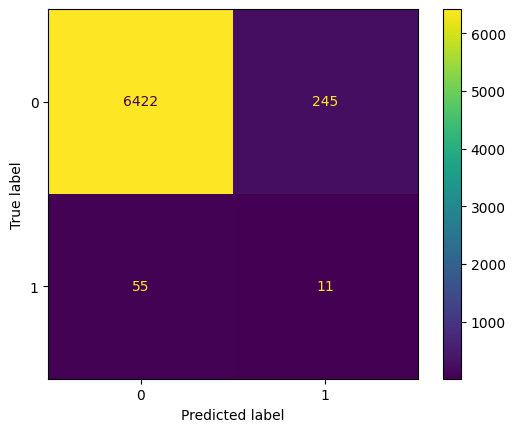

In [67]:
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred_binary)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1 Score:', f1)
print('AUC:', auc)

ConfusionMatrixDisplay(confusion).plot()

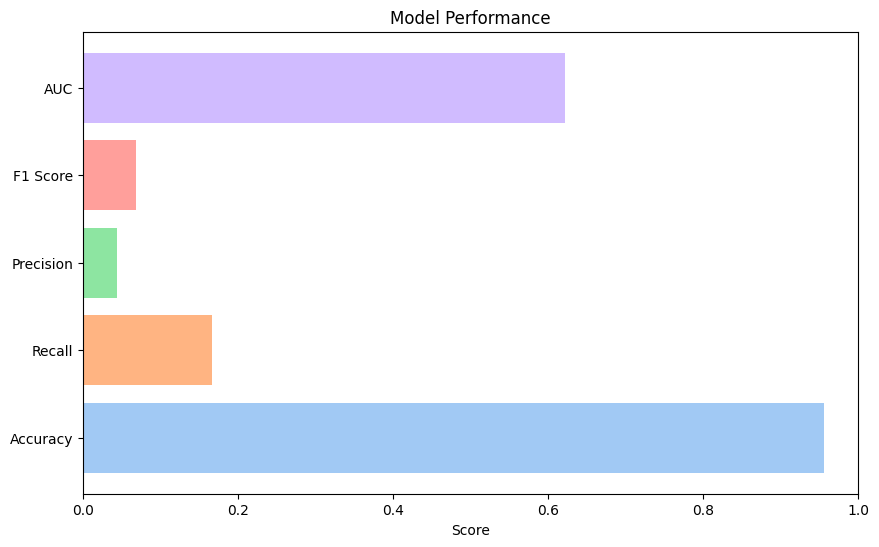

In [68]:
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC']
values = [accuracy, recall, precision, f1, auc]
colors = sns.color_palette('pastel', len(metrics))

plt.figure(figsize=(10, 6))
plt.barh(metrics, values, color=colors)
plt.xlabel('Score')
plt.title('Model Performance')
plt.xlim(0, 1)
plt.show()

In [70]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance': gbm.feature_importance()})
importance = importance.sort_values('importance', ascending=False)
print(importance)

                     feature  importance
1            DTDmedianNonFin        5268
19         price_to_earnings        2736
3                        sic        2503
20           retention_ratio        2122
7                 cash_ratio        1906
13    cashflow_to_debt_ratio        1628
14         net_profit_margin        1627
18  working_capital_turnover        1473
4                        atq        1451
15            asset_turnover        1420
8        net_working_capital        1395
16      receivables_turnover        1313
5              current_ratio        1308
6                quick_ratio        1305
10      debt_to_equity_ratio        1260
17     day_sales_outstanding        1218
12  financial_leverage_ratio        1204
11              equity_ratio        1143
9                 debt_ratio        1058
0               DTDmedianFin         662
2                dummy297fin           0


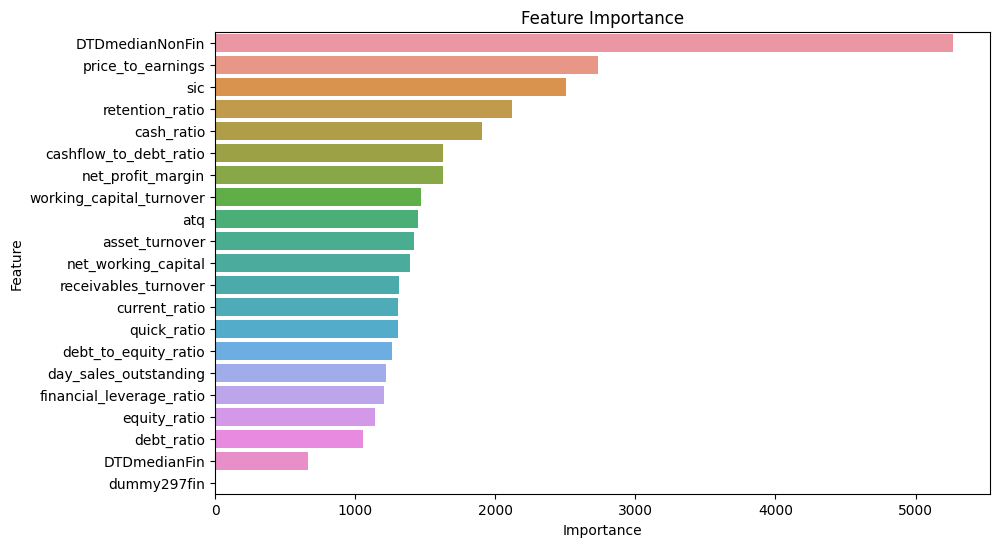

In [72]:
feature_importance = gbm.feature_importance()
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [ ]:
model = LGBMClassifier()
model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)
y_pred_binary = np.round(pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 463380, number of used features: 21
[LightGBM] [Info] Start training from score -0.007880
[LightGBM] [Info] Start training from score -4.850693
[LightGBM] [Info] Start training from score -10.561396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train_scaled,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test_scaled,y_test)))

Training accuracy 0.9921
Testing accuracy 0.9919


In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test_scaled)))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    115004
         1.0       0.28      0.07      0.11       839
         2.0       0.00      0.00      0.00         2

    accuracy                           0.99    115845
   macro avg       0.42      0.36      0.37    115845
weighted avg       0.99      0.99      0.99    115845



<font size="6">Testing LightGBM model with filled_table</font>

In [ ]:
from google.oauth2 import service_account
import pandas as pd
import pandas_gbq as gbq
credentials_path = 'data_cleaning/token.json'

# Authenticate with your credentials
credentials = service_account.Credentials.from_service_account_file(
    credentials_path, scopes=['https://www.googleapis.com/auth/bigquery'])

# Set the credentials for pandas_gbq
gbq.context.credentials = credentials

In [ ]:
project_id = 'capstone-398012'
dataset_id = 'capstone'
table_id = "filled_table"

In [ ]:
from pandas_gbq import read_gbq

query = f"""
SELECT *
FROM `{project_id}.{dataset_id}.{table_id}`

"""

# Authenticate and read data from BigQuery into a DataFrame
df = read_gbq(query, project_id=project_id, dialect='standard')
df

/usr/local/lib/python3.9/site-packages/google/cloud/bigquery/table.py:2155: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
#drop na rows
test_df = df.dropna()
test_df

,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
#map event type
test_df['Event_type'] = test_df['Event_type'].map(lambda x : 0 if x ==2  else x)
test_df

/var/folders/rz/d40gjr2505ddk3wl3mnzmvdm0000gn/T/ipykernel_15768/3448417843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Event_type'] = test_df['Event_type'].map(lambda x : 0 if x ==2  else x)


,CompNo,yyyy,mm,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,1990,1,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,...,3,1,1,0,0,0,1,1,1,1
1,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
2,26996,1990,1,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,...,3,1,1,0,0,0,1,1,1,1
3,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
4,27000,1990,1,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12335,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12336,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1
12337,27058,2023,7,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
X = test_df.drop(['Event_type', 'yyyy', 'mm', 'EventDate'], axis=1)  # Features
y = test_df['Event_type']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
class_weights = {0:1, 1:100}
model = LGBMClassifier( class_weight = class_weights)
model.fit(X_train, y_train)
pred = model.predict(X_test)

[LightGBM] [Info] Number of positive: 727, number of negative: 9015
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4108
[LightGBM] [Info] Number of data points in the train set: 9742, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.889678 -> initscore=2.087452
[LightGBM] [Info] Start training from score 2.087452


In [ ]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 0.7540
Testing accuracy 0.6773


In [ ]:
print(metrics.classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.68      0.80      2254
           1       0.14      0.67      0.24       182

    accuracy                           0.68      2436
   macro avg       0.55      0.67      0.52      2436
weighted avg       0.90      0.68      0.75      2436



push updated table to gbq, ie the table used for modeling

In [ ]:
new_df = df.dropna()
new_df = new_df.drop(['yyyy', 'mm', 'EventDate'], axis=1,)
new_df['Event_type'] = new_df['Event_type'].map(lambda x : 0 if x ==2  else x)
new_df

,CompNo,StkIndx,STInt,dtdlevel,dtdtrend,liqnonfinlevel,liqnonfintrend,ni2talevel,ni2tatrend,sizelevel,...,nan_count,liqnonfinlevel_notNA,liqnonfintrend_notNA,dtdlevel_notNA,dtdtrend_notNA,DTDmedianNonFin_notNA,Sector_Number_notNA,DTDmedianFin_notNA,sigma_notNA,StkIndx_notNA
0,26995,0.106263,0.020305,3.176331,-0.148469,0.280325,-0.146216,0.002395,0.001367,0.666644,...,3,1,1,0,0,0,1,1,1,1
1,26996,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,-0.000224,0.014110,...,3,1,1,0,0,0,1,1,1,1
2,26996,0.106263,0.020305,4.401022,0.054801,0.951410,0.033574,0.002635,-0.000224,0.014110,...,3,1,1,0,0,0,1,1,1,1
3,27000,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,0.004625,1.248517,...,3,1,1,0,0,0,1,1,1,1
4,27000,0.106263,0.020305,2.908823,0.056226,-0.312616,-0.149733,0.004073,0.004625,1.248517,...,3,1,1,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12334,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12335,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12336,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1
12337,27058,0.110445,0.009928,6.832332,2.326057,0.673112,-0.089241,0.006030,0.000547,5.101596,...,0,1,1,1,1,1,1,1,1,1


In [ ]:
new_df.to_gbq(destination_table=f'{project_id}.{dataset_id}.filled_table', project_id=project_id, if_exists='replace')